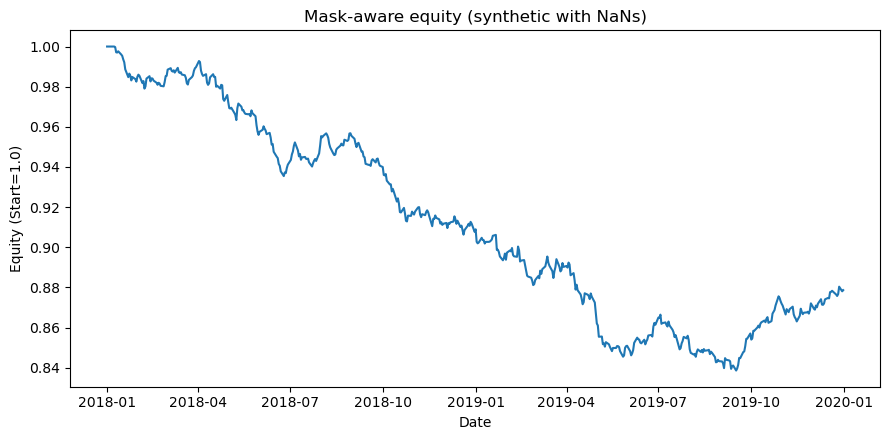

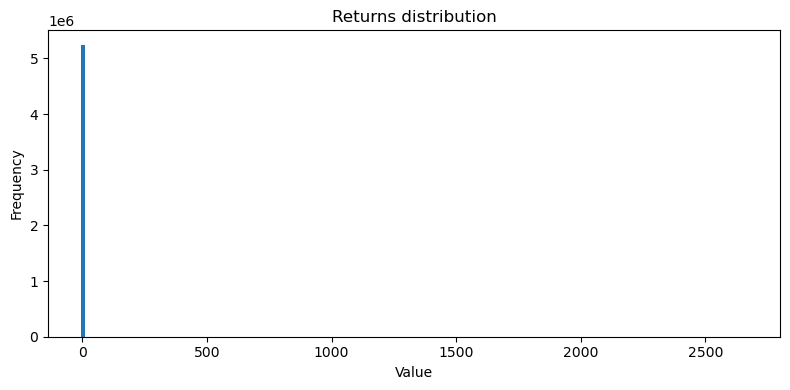

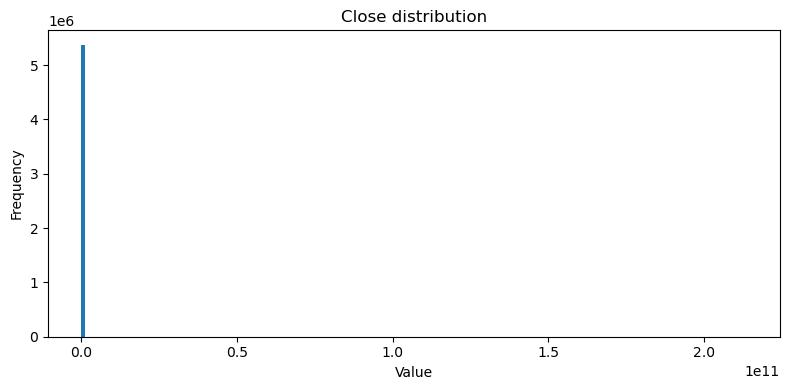

C:\Users\g3055\AppData\Local\Temp\ipykernel_46972\216571597.py:86: RuntimeWarning: invalid value encountered in log
  _plot_hist(np.log(close.to_numpy().astype(float)).ravel(), "Log(Close) distribution", bins=200, filename=f"{outdir}/hist_log_close.png")


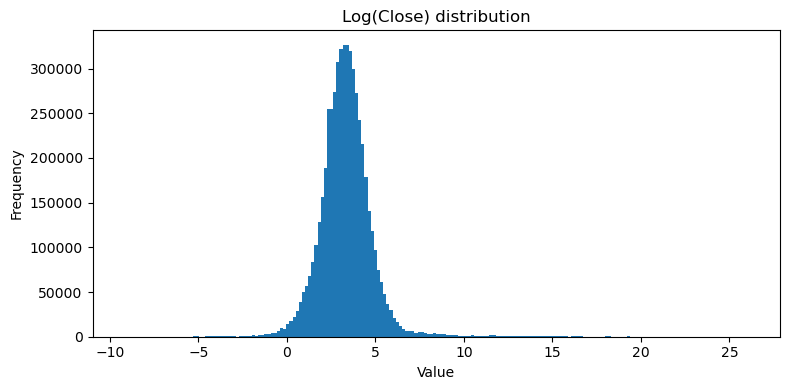

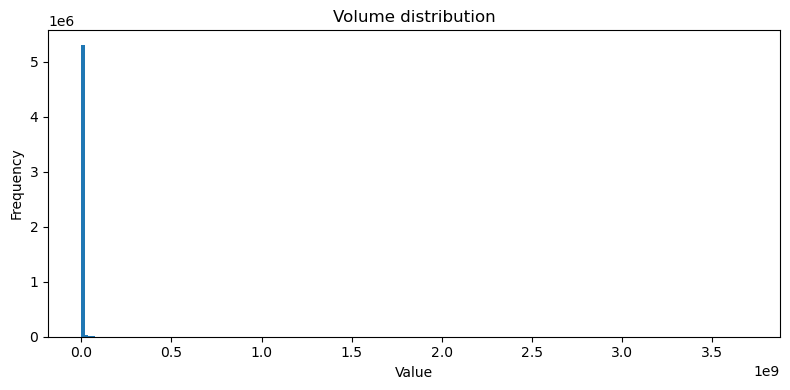

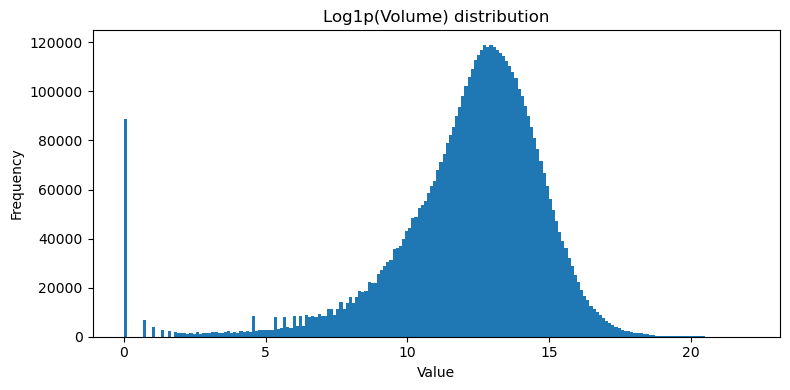

           count  missing_pct        min        1%           5%           25%  \
name                                                                            
returns  7372197    28.892459  -3.758620 -0.097927    -0.047847     -0.012431   
close    7372197    27.113966 -37.709606  0.890000     3.180000     12.112698   
volume   7372197    27.113966   0.000000  0.000000  1030.000000  59200.000000   

                   50%           75%           95%           99%  \
name                                                               
returns       0.000000  1.264287e-02  4.829209e-02  1.105958e-01   
close        26.712832  5.845000e+01  2.348000e+02  4.500000e+03   
volume   295500.000000  1.077900e+06  5.947203e+06  2.064960e+07   

                  max          mean           std         skew      kurtosis  \
name                                                                           
returns  2.665667e+03  2.160561e-03  1.450863e+00  1419.398938  2.334878e+06   
close    2.13

In [1]:
%run function_sets.ipynb

turnover:0.3406305421560773
{'ann_sharpe': 1.3849853170607351, 'cagr': 0.18142661846022112, 'tot_return': 2.910063316438177, 'ann_vol': 0.12615149457219993, 'max_drawdown': -0.1701030743442593}


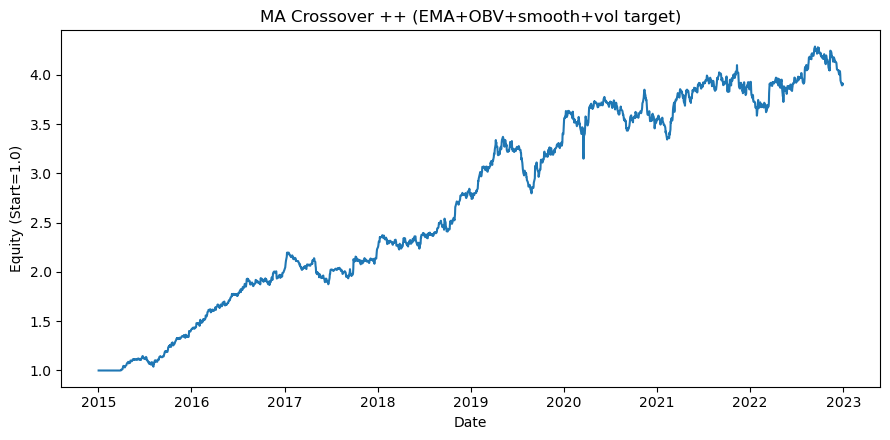

In [3]:
from alpha_maco_safe import alpha_maco_plus, neutralize_by_group, vol_target_weights


# 1) Alpha: EMA crossover + OBV + smoothing + robust gating
alpha = alpha_maco_plus(
    close, volume,
    fast_span=5, slow_span=15, atr_window=15,
    threshold_q=0.9, top_frac=0.10, min_keep=300,
    use_obv_filter=True, obv_span=15,
    smooth_span=5,
    mask=build_tradable_mask(close, volume, 1.0, 1.0)
)

# 2) Weights (z-score ranks, dollar-neutral, mask-aware)
weights = make_weights(alpha, gross_exposure=1.0, cap_per_name=0.003,
                       neutralize=True, method="zscore",
                       mask=build_tradable_mask(close, volume, 1.0, 1.0), min_names=50)

# 2b) Optional: sector/industry neutrality (if you built a Series ticker->sector)
# weights = neutralize_by_group(weights, sector_map_series)

# 3) Volatility targeting (ex-ante, no lookahead)
rets = close.pct_change(fill_method=None)
weights_vt = vol_target_weights(weights, rets, target_ann_vol=0.12, lookback=60, max_leverage=3.0)

# 4) Backtest
bt = backtest_long_short(weights_vt, rets, cost_bps=2)
print(f"turnover:{float(bt['two_way_turnover'].mean())}")
print(performance_stats(bt["ret_net"]))
plot_equity_curve(bt["ret_net"], title="MA Crossover ++ (EMA+OBV+smooth+vol target)")


{'n_active': Date
2015-01-02       0
2015-01-05       0
2015-01-06       0
2015-01-07       0
2015-01-08       0
              ... 
2022-12-23    3318
2022-12-27    3314
2022-12-28    3319
2022-12-29    3320
2022-12-30    3321
Name: n_active, Length: 2061, dtype: int64, 'n_kept': Date
2015-01-02      0
2015-01-05      0
2015-01-06      0
2015-01-07      0
2015-01-08      0
             ... 
2022-12-23    577
2022-12-27    577
2022-12-28    578
2022-12-29    578
2022-12-30    578
Name: n_kept, Length: 2061, dtype: int64, 'device': 'cuda', 'hard_capped_frac': 6.432683585444465e-05}
turnover:0.2645367074340154
{'ann_sharpe': 1.5090708894037825, 'cagr': 0.1352371510771726, 'tot_return': 1.8218222470519798, 'ann_vol': 0.08653745679311031, 'max_drawdown': -0.14058732500565108}


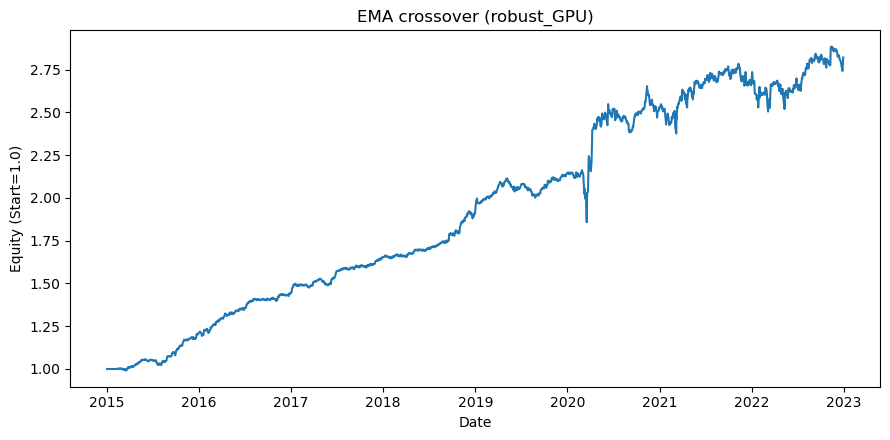

In [5]:
# pip install torch with CUDA if you haven't (pick your CUDA version):
# pip install torch --index-url https://download.pytorch.org/whl/cu121

from alpha_maco_plus_gpu import alpha_ema_crossover_gpu

alpha_gpu, diag = alpha_ema_crossover_gpu(
    close, volume,
    fast_span=5, slow_span=12, atr_span=12,
    use_global_mad_winsor=True,   # robust to your heavy tails
    threshold_q=0.9,mad_k = 3, top_frac=0.15, min_keep=300,
    stale_span=3, stale_std_bp=1.0,
    hard_cap_abs_return=1,
    smooth_span=3,               # EWMA smoothing
    device="cuda"                  # or leave None to auto-pick
)
print(diag)                        # shows device and data-cleaning fractions

# Then continue exactly as before (mask-aware weights + backtest)
tradable = build_tradable_mask(close, volume, 1.0, 1.0)
weights = make_weights(alpha_gpu, gross_exposure=1.0, cap_per_name=0.005,
                       neutralize=True, method="zscore", mask=tradable, min_names=50)
rets = close.pct_change(fill_method=None)
bt = backtest_long_short(weights, rets, cost_bps=2)
print(f"turnover:{float(bt['two_way_turnover'].mean())}")
print(performance_stats(bt["ret_net"]))
plot_equity_curve(bt["ret_net"], title="EMA crossover (robust_GPU)")


[1/12] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 2.0, 'top_frac': 0.1, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[2/12] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 2.0, 'top_frac': 0.15, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[3/12] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 2.0, 'top_frac': 0.05, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[4/12] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.95, 'mad_k': 2.0, 'top_frac': 0.1, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[5/12] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.95, 'mad_k': 2.0, 't

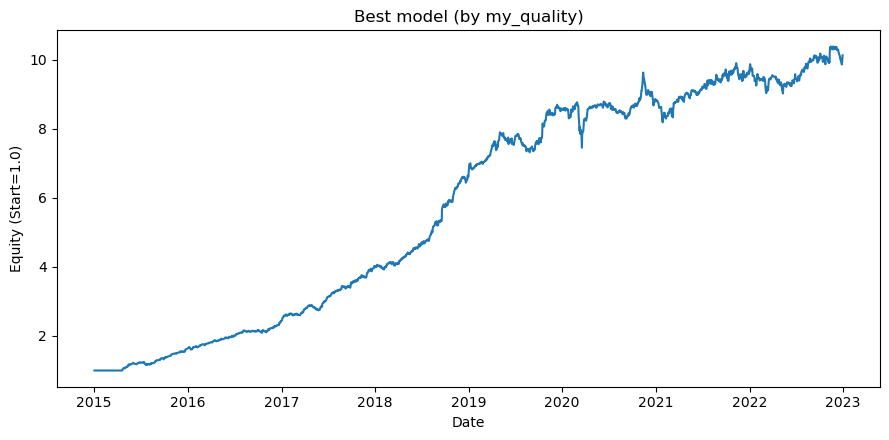

In [8]:
from grid_search_pipeline import grid_search_alpha
from quality_kinked import make_kinked_quality_fn

param_grid = {
    "fast_span": [4],
    "slow_span": [9],
    "atr_span":  [30, 36],          # for GPU version (robust vol span)
    "threshold_q": [0.90,0.95],
    'mad_k' : [2.0],
    "top_frac":   [0.1,0.15,0.05],
    "min_keep":   [180],
    "stale_span": [5],
    "stale_std_bp": [1.0],
    "hard_cap_abs_return": [0.8],
    "smooth_span": [2],
    "device": ["cuda"],             # for GPU alpha; drop for CPU alpha
}

cfg = {
    "sharpe":     {"range": (1.5, 1.8), "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
    "turnover":   {"range": (0.25, 3), "higher_is_better": False, "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
    "max_weight": {"range": (0.05, 0.0), "higher_is_better": False, "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
    "tot_return": {"range": (2, 2.5), "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
}

# Optional metric weights (equal by default)
weights = {"sharpe": 1.0, "turnover": 1.0, "max_weight": 1.0, "tot_return": 1.0}
quality_fn = make_kinked_quality_fn(cfg, weights=weights)

# Weighting / backtest settings from our pipeline
mw_kwargs = dict(gross_exposure=1.0, cap_per_name=0.01, neutralize=True,
                 method="zscore", mask=build_tradable_mask(close, volume, 1.0, 1.0), min_names=50)
bt_kwargs = dict(cost_bps=5)
vt_kwargs = dict(target_ann_vol=0.10, lookback=60, max_leverage=3.0)

# 2) Use with your existing grid search
results_df, best = grid_search_alpha(
    alpha_fn=alpha_ema_crossover_gpu,    # or alpha_ema_crossover_robust
    param_grid=param_grid,               # your grid dict
    close=close, volume=volume,
    make_weights_fn=make_weights,
    make_weights_kwargs=mw_kwargs,
    backtest_fn=backtest_long_short,
    backtest_kwargs=bt_kwargs,
    vol_target_fn=vol_target_weights,
    vol_target_kwargs=vt_kwargs,
    returns=close.pct_change(fill_method=None),
    quality_fn=quality_fn,
    alpha_static_kwargs=None,
    progress=True,
    save_csv="/mnt/data/grid_results.csv",
    return_artifacts=True
)

print("Best params:", best["params"])
print("Best metrics:", best["metrics"])
plot_equity_curve(best["ret_net"], title="Best model (by my_quality)")